# Question 1
### Select the best model to predict resale price for HDB flats in 2014

In [1]:
## Import libraries necessary for this project
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import ShuffleSplit
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from sklearn.neighbors import KNeighborsRegressor

## Pretty display for notebooks
%matplotlib inline

In [2]:
## load the flat prices datasets
flat_prices = pd.read_csv("/Users/sakhuja/Desktop/resale-flat-prices/combined_resale_flat_prices.csv")

/Users/sakhuja/opt/anaconda3/envs/skillsml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
## Describe the dataset
flat_prices.describe()
#flat_prices['resale_price'].describe()

,floor_area_sqm,lease_commence_date,resale_price
count,806568.000000,806568.000000,8.065680e+05
mean,95.521553,1986.929255,2.899247e+05
std,26.098792,9.203611,1.468548e+05
min,28.000000,1966.000000,5.000000e+03
25%,73.000000,1980.000000,1.800000e+05
50%,93.000000,1986.000000,2.710000e+05
75%,114.000000,1993.000000,3.800000e+05
max,307.000000,2016.000000,1.205000e+06



 mu = 289924.73 and sigma = 146854.73



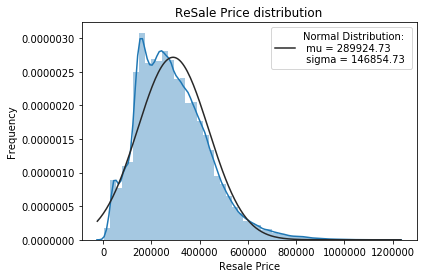

Skewness: 0.815261
Kurtosis: 1.055519


In [4]:
## Plot Histogram
sns.distplot(flat_prices['resale_price'], fit=norm)

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(flat_prices['resale_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal Distribution: \n mu = {:.2f}\n sigma = {:.2f}'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.xlabel('Resale Price')
plt.title('ReSale Price distribution')
plt.show()

print("Skewness: %f" % flat_prices['resale_price'].skew())
print("Kurtosis: %f" % flat_prices['resale_price'].kurt())

In [5]:
## Feature Engineering variables

flat_prices['street_names'] = flat_prices.street_name.str.replace('[0-9]', '').str.strip()
flat_prices = flat_prices.drop(['street_name'], axis=1)

In [6]:
flat_prices.shape

(806568, 11)

In [7]:
## Find Missing Ratio of Dataset
missing_data_na = (flat_prices.isnull().sum()/len(flat_prices))*100
missing_data = pd.DataFrame({'Missing Ratio': missing_data_na})
missing_data

,Missing Ratio
block,0.000000
flat_model,0.000000
flat_type,0.000000
floor_area_sqm,0.000000
lease_commence_date,0.000000
month,0.000000
remaining_lease,87.910009
resale_price,0.000000
storey_range,0.000000
town,0.000000


Text(0.5, 1.0, 'Percent missing data by feature')

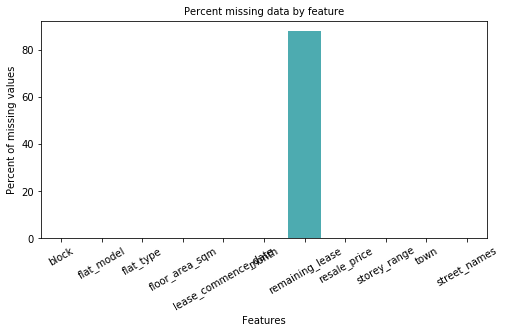

In [8]:
# Percent missing data by feature
f, ax = plt.subplots(figsize=(8, 4))
plt.xticks(rotation='30')
sns.barplot(x=missing_data_na.index, y=missing_data_na)
plt.xlabel('Features', fontsize=10)
plt.ylabel('Percent of missing values', fontsize=10)
plt.title('Percent missing data by feature', fontsize=10)

In [9]:
## Removing features whose missing percentage is higher than 50%
flat_prices = flat_prices.drop('remaining_lease', axis=1)

## Correlation between variables

,floor_area_sqm,lease_commence_date,resale_price
floor_area_sqm,1.000000,0.484775,0.631418
lease_commence_date,0.484775,1.000000,0.495120
resale_price,0.631418,0.495120,1.000000


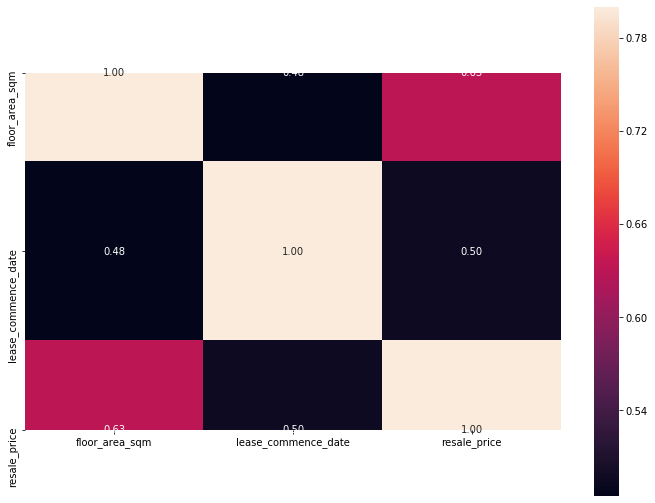

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation Matrix Heatmap
corrmat = flat_prices.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, cbar=True, annot=True, fmt='.2f');

# Find the correlation among variables
flat_prices.corr(method ='pearson')

## Plotting Variables 

Text(0, 0.5, 'Resale Price')

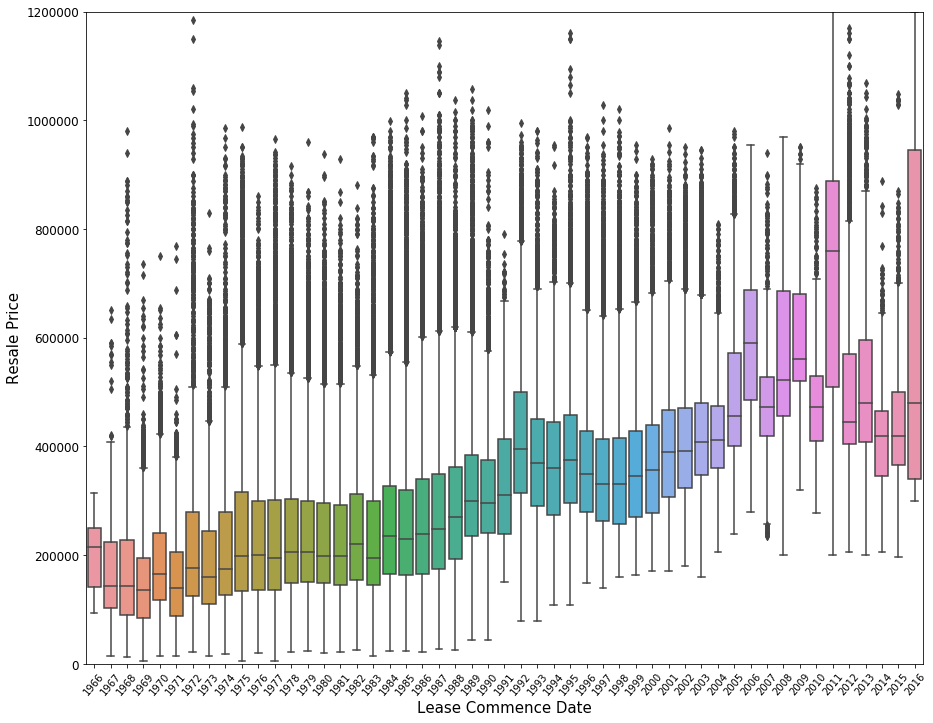

In [11]:
# Lease Commence Date vs Resale Price
data = pd.concat([flat_prices['resale_price'], flat_prices['lease_commence_date']], axis=1)
f, ax = plt.subplots(figsize=(15, 12))
fig = sns.boxplot(x='lease_commence_date', y="resale_price", data=data)
fig.axis(ymin=0, ymax=1200000);
plt.xticks(rotation='50', fontsize=10)
plt.yticks(fontsize=12)
plt.xlabel("Lease Commence Date", fontsize=15)
plt.ylabel("Resale Price", fontsize=15)

Text(0, 0.5, 'Resale Price')

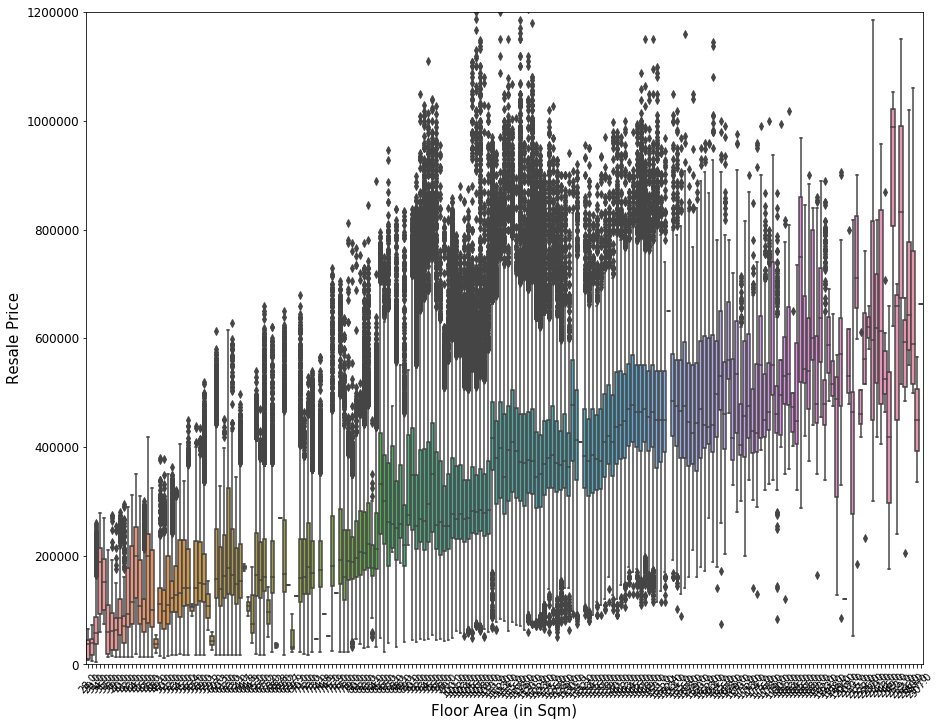

In [12]:
# Floor Area vs Resale Price
data = pd.concat([flat_prices['resale_price'], flat_prices['floor_area_sqm']], axis=1)
f, ax = plt.subplots(figsize=(15, 12))
fig = sns.boxplot(x='floor_area_sqm', y="resale_price", data=data)
fig.axis(ymin=0, ymax=1200000);
plt.xticks(rotation='50', fontsize=10)
plt.yticks(fontsize=12)
plt.xlabel("Floor Area (in Sqm)", fontsize=15)
plt.ylabel("Resale Price", fontsize=15)

Text(0, 0.5, 'Resale Price')

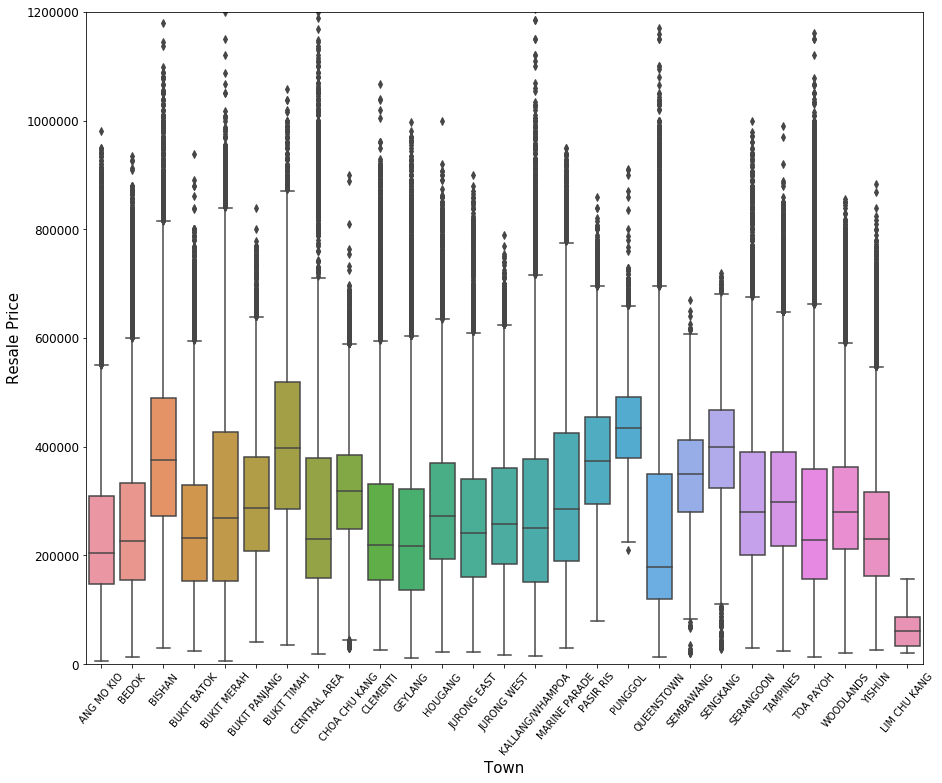

In [13]:
# Town vs Resale Price
data = pd.concat([flat_prices['resale_price'], flat_prices['town']], axis=1)
f, ax = plt.subplots(figsize=(15, 12))
fig = sns.boxplot(x='town', y="resale_price", data=data)
fig.axis(ymin=0, ymax=1200000);
plt.xticks(rotation='50', fontsize=10)
plt.yticks(fontsize=12)
plt.xlabel("Town", fontsize=15)
plt.ylabel("Resale Price", fontsize=15)

In [14]:
## Flat Price in 2014
flat_prices_new=flat_prices
flat_prices_2014=flat_prices_new[flat_prices_new['month'].str[:4] =='2014']
flat_prices_2014_label=flat_prices_2014['resale_price']

In [15]:
## Checking Categorical Data
print('before: ', flat_prices.select_dtypes(include=object).columns)

## Removing non-required categorical objects for modelling
flat_prices = flat_prices.drop(['block', 'month'], axis=1)

print('After: ', flat_prices.select_dtypes(include=object).columns)

before:  Index(['block', 'flat_model', 'flat_type', 'month', 'storey_range', 'town',
       'street_names'],
      dtype='object')
After:  Index(['flat_model', 'flat_type', 'storey_range', 'town', 'street_names'], dtype='object')


In [16]:
## Encoding categorical data

## Features
X_data = pd.get_dummies(flat_prices,
                        columns=flat_prices.select_dtypes(include=object).columns).drop('resale_price', axis=1)

## Label
y_data = flat_prices['resale_price']


## Encoding categorical data - Test Data in 2014

## Features
X_data_2014 = pd.merge(flat_prices_2014_label, X_data, left_index=True, right_index=True).drop('resale_price', axis=1)

## Label
y_data_2014 = flat_prices_2014_label

In [17]:
# Splitting the data

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=4)

## Regression Models

### Model 1: Linear Regression

In [18]:
## Linear Model Selection and Prediction

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
reg_pred=reg.predict(X_test)
reg_pred_2014=reg.predict(X_data_2014)

In [20]:
## Test Data Results
print("Test Regression Score: %.3f" % reg.score(X_test, y_test))

# Calculate the Root Mean Squared Error
rms = sqrt(mean_squared_error(y_test, reg_pred))
print("Test RMSE: %.2f" % rms)

Test Regression Score: 0.667
Test RMSE: 84540.48


Text(0.5, 1.0, 'Resale Price Predicted: Regression Model')

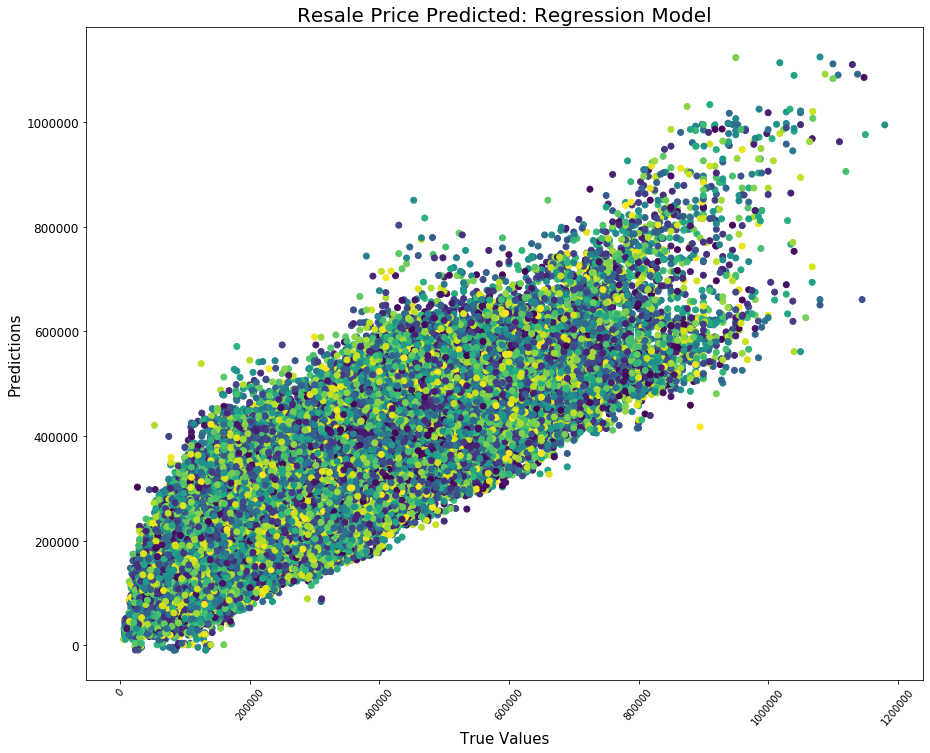

In [22]:
# Test Data Plot
colors = np.random.rand(y_test.count())
plt.subplots(figsize=(15, 12))
plt.scatter(y_test, reg_pred, c=colors)
plt.xticks(rotation='50', fontsize=10)
plt.yticks(fontsize=12)
plt.xlabel("True Values", fontsize=15)
plt.ylabel("Predictions", fontsize=15)
plt.title("Resale Price Predicted: Regression Model", fontsize=20)

Text(0.5, 1.0, 'Resale Price 2014 Predicted: Regression Model')

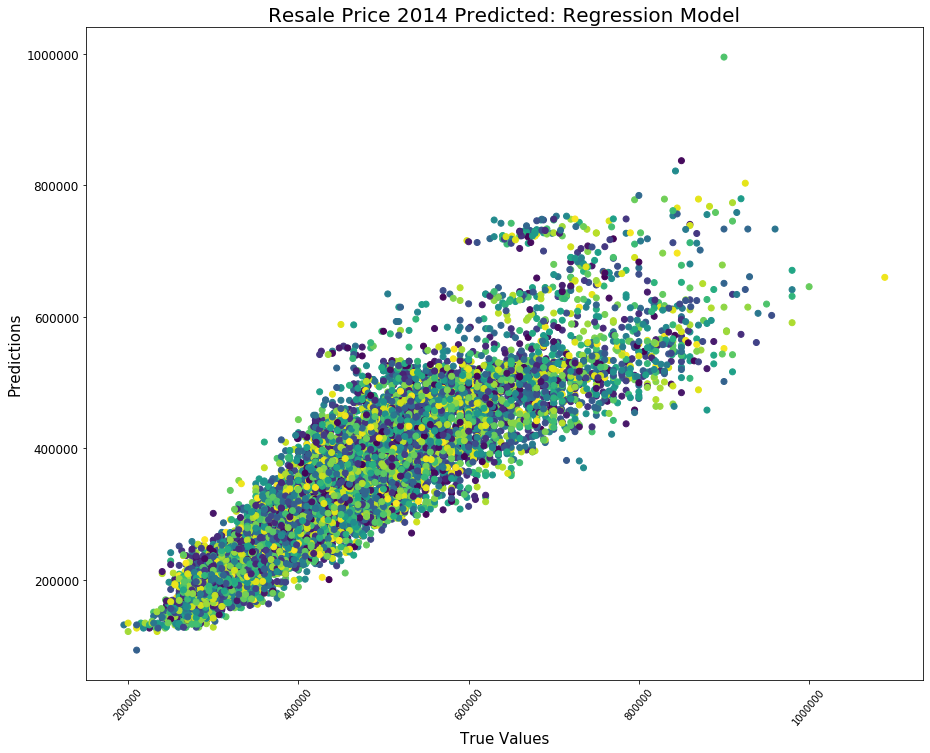

In [24]:
# 2014 Data Plot
colors = np.random.rand(y_data_2014.count())
plt.subplots(figsize=(15, 12))
plt.scatter(y_data_2014, reg_pred_2014, c=colors)
plt.xticks(rotation='50', fontsize=10)
plt.yticks(fontsize=12)
plt.xlabel("True Values", fontsize=15)
plt.ylabel("Predictions", fontsize=15)
plt.title("Resale Price 2014 Predicted: Regression Model", fontsize=20)

In [25]:
# Prediction in 2014

reg_pred_df = pd.DataFrame({'Actual_Resale_Price': y_data_2014, 'Predicted_Resale_Price': reg_pred_2014})
reg_pred_df_test = reg_pred_df[['Predicted_Resale_Price']]
reg_finalPrediction=pd.merge(flat_prices_2014, reg_pred_df_test, left_index=True, right_index=True)

In [26]:
## Flat Price Prediction in 2014
reg_finalPrediction

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,resale_price,storey_range,town,street_names,Predicted_Resale_Price
36107,510,Improved,2 ROOM,44.0,1980,2014-01,280000.0,07 TO 09,ANG MO KIO,ANG MO KIO AVE,151503.781250
36108,603,New Generation,3 ROOM,67.0,1980,2014-01,290000.0,07 TO 09,ANG MO KIO,ANG MO KIO AVE,234579.343750
36109,476,New Generation,3 ROOM,67.0,1979,2014-01,300000.0,04 TO 06,ANG MO KIO,ANG MO KIO AVE,225212.820312
36110,558,New Generation,3 ROOM,67.0,1980,2014-01,315000.0,01 TO 03,ANG MO KIO,ANG MO KIO AVE,224535.187500
36111,605,New Generation,3 ROOM,67.0,1980,2014-01,318000.0,01 TO 03,ANG MO KIO,ANG MO KIO AVE,224535.187500
...,...,...,...,...,...,...,...,...,...,...,...
52198,816,Improved,5 ROOM,122.0,1988,2014-12,580000.0,10 TO 12,YISHUN,YISHUN ST,384173.453125
52199,325,Maisonette,EXECUTIVE,146.0,1988,2014-12,540000.0,10 TO 12,YISHUN,YISHUN CTRL,494535.640625
52200,618,Apartment,EXECUTIVE,164.0,1992,2014-12,738000.0,07 TO 09,YISHUN,YISHUN RING RD,507149.015625
52201,277,Maisonette,EXECUTIVE,152.0,1985,2014-12,592000.0,07 TO 09,YISHUN,YISHUN ST,491199.187500


### Removing the duplicate values 
#### This step was messing with data:
* #### Remove the duplicates from the file
sample = flat_prices.drop_duplicates()

* #### Features
X_data = pd.get_dummies(flat_prices,
                        columns=flat_prices.select_dtypes(include=object).columns).drop('resale_price', axis=1)

* #### Label
y_data = flat_prices['resale_price']

* #### Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=4)

* #### Model Selection, Training and Prediction
reg = LinearRegression()
reg.fit(X_train, y_train)
xpredict=reg.predict(X_test)

* #### Regression Score:
print("Regression Score: %.3f" % reg.score(X_test, y_test))

* #### Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((reg.predict(X_test) - y_test) ** 2)))
      
 
* #### Output
Regression Score: -1817100264.221
RMSE: 6274061146.29

### Model 2: Gradient Boosting

In [27]:
## Using Gradient Boosting to boost the accuracy

from sklearn import ensemble
gbr = ensemble.GradientBoostingRegressor(n_estimators=400, max_depth=5, min_samples_split=2, 
                                         learning_rate=0.1, loss='ls')
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [28]:
gbr_pred = gbr.predict(X_test)
gbr_pred_2014=gbr.predict(X_data_2014)

## Accuracy Score with GBoost
print("Gradient Boost Score: %.3f" % gbr.score(X_test, y_test))

## Calculate Root Mean Squared Error
rms = sqrt(mean_squared_error(y_test, gbr_pred))
print("RMSE:", rms)

Gradient Boost Score: 0.695
RMSE: 80946.96642926679


In [29]:
# Prediction in 2014

gbr_pred_df = pd.DataFrame({'Actual_Resale_Price': y_data_2014, 'Predicted_Resale_Price': gbr_pred_2014})
gbr_pred_df_test = gbr_pred_df[['Predicted_Resale_Price']]
gbr_finalPrediction=pd.merge(flat_prices_2014, gbr_pred_df_test, left_index=True, right_index=True)

In [30]:
## Flat Price Prediction in 2014
gbr_finalPrediction

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,resale_price,storey_range,town,street_names,Predicted_Resale_Price
36107,510,Improved,2 ROOM,44.0,1980,2014-01,280000.0,07 TO 09,ANG MO KIO,ANG MO KIO AVE,178837.073823
36108,603,New Generation,3 ROOM,67.0,1980,2014-01,290000.0,07 TO 09,ANG MO KIO,ANG MO KIO AVE,224143.260603
36109,476,New Generation,3 ROOM,67.0,1979,2014-01,300000.0,04 TO 06,ANG MO KIO,ANG MO KIO AVE,222101.370388
36110,558,New Generation,3 ROOM,67.0,1980,2014-01,315000.0,01 TO 03,ANG MO KIO,ANG MO KIO AVE,216596.448184
36111,605,New Generation,3 ROOM,67.0,1980,2014-01,318000.0,01 TO 03,ANG MO KIO,ANG MO KIO AVE,216596.448184
...,...,...,...,...,...,...,...,...,...,...,...
52198,816,Improved,5 ROOM,122.0,1988,2014-12,580000.0,10 TO 12,YISHUN,YISHUN ST,368676.482791
52199,325,Maisonette,EXECUTIVE,146.0,1988,2014-12,540000.0,10 TO 12,YISHUN,YISHUN CTRL,474341.072290
52200,618,Apartment,EXECUTIVE,164.0,1992,2014-12,738000.0,07 TO 09,YISHUN,YISHUN RING RD,548066.990657
52201,277,Maisonette,EXECUTIVE,152.0,1985,2014-12,592000.0,07 TO 09,YISHUN,YISHUN ST,469666.208551


### Model 3: Extreme Gradient Boosting

In [31]:
## Model Prediction using XGBoost
#xgbmodel = xgb.XGBRegressor()

xgbmodel = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.5,
                           colsample_bytree=1, max_depth=7)
xgbmodel.fit(X_train, y_train)

/Users/sakhuja/opt/anaconda3/envs/skillsml/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:48:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.5, verbosity=1)

In [32]:
## Prediction on test data
xgb_pred= xgbmodel.predict(X_test)
xgb_pred_2014=xgbmodel.predict(X_data_2014)

## Accuracy Score with XGBoost
print("XGBoost Score: %.3f" % explained_variance_score(y_test, xgb_pred))
#OR
#print("XGBoost Score: %.3f" % xgbmodel.score(X_test, y_test))

## Calculate Root Mean Squared Error
rms = sqrt(mean_squared_error(y_test, xgb_pred))
print("RMSE:", rms)

XGBoost Score: 0.688
RMSE: 81800.63308687902


In [33]:
# Prediction in 2014

xgb_pred_df = pd.DataFrame({'Actual_Resale_Price': y_data_2014, 'Predicted_Resale_Price': xgb_pred_2014})
xgb_pred_df_test = xgb_pred_df[['Predicted_Resale_Price']]
xgb_finalPrediction=pd.merge(flat_prices_2014, xgb_pred_df_test, left_index=True, right_index=True)

In [34]:
## Flat Price Prediction in 2014
xgb_finalPrediction

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,resale_price,storey_range,town,street_names,Predicted_Resale_Price
36107,510,Improved,2 ROOM,44.0,1980,2014-01,280000.0,07 TO 09,ANG MO KIO,ANG MO KIO AVE,186591.812500
36108,603,New Generation,3 ROOM,67.0,1980,2014-01,290000.0,07 TO 09,ANG MO KIO,ANG MO KIO AVE,221880.640625
36109,476,New Generation,3 ROOM,67.0,1979,2014-01,300000.0,04 TO 06,ANG MO KIO,ANG MO KIO AVE,220262.390625
36110,558,New Generation,3 ROOM,67.0,1980,2014-01,315000.0,01 TO 03,ANG MO KIO,ANG MO KIO AVE,216708.703125
36111,605,New Generation,3 ROOM,67.0,1980,2014-01,318000.0,01 TO 03,ANG MO KIO,ANG MO KIO AVE,216708.703125
...,...,...,...,...,...,...,...,...,...,...,...
52198,816,Improved,5 ROOM,122.0,1988,2014-12,580000.0,10 TO 12,YISHUN,YISHUN ST,371205.593750
52199,325,Maisonette,EXECUTIVE,146.0,1988,2014-12,540000.0,10 TO 12,YISHUN,YISHUN CTRL,471796.281250
52200,618,Apartment,EXECUTIVE,164.0,1992,2014-12,738000.0,07 TO 09,YISHUN,YISHUN RING RD,523519.218750
52201,277,Maisonette,EXECUTIVE,152.0,1985,2014-12,592000.0,07 TO 09,YISHUN,YISHUN ST,476087.500000


### Model 4: KNN Clustering (Supervised for Regression)

In [35]:
# Run K-NN model
kn = KNeighborsRegressor(n_neighbors=15)
kn.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='uniform')

In [36]:
kn_pred = kn.predict(X_test)
kn_pred_2014=kn.predict(X_data_2014)

## Predicting the score
print('KNN Score %.2f' % kn.score(X_test, y_test))

## RMSE the score
print('RMSE %.2f' % sqrt(mean_squared_error(y_test, kn_pred)))

KNN Score 0.67
RMSE 83745.95


In [37]:
# Prediction in 2014

kn_pred_df = pd.DataFrame({'Actual_Resale_Price': y_data_2014, 'Predicted_Resale_Price': kn_pred_2014})
kn_pred_df_test = kn_pred_df[['Predicted_Resale_Price']]
kn_finalPrediction=pd.merge(flat_prices_2014, kn_pred_df_test, left_index=True, right_index=True)

In [38]:
## Flat Price Prediction in 2014
kn_finalPrediction

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,resale_price,storey_range,town,street_names,Predicted_Resale_Price
36107,510,Improved,2 ROOM,44.0,1980,2014-01,280000.0,07 TO 09,ANG MO KIO,ANG MO KIO AVE,211886.666667
36108,603,New Generation,3 ROOM,67.0,1980,2014-01,290000.0,07 TO 09,ANG MO KIO,ANG MO KIO AVE,232566.666667
36109,476,New Generation,3 ROOM,67.0,1979,2014-01,300000.0,04 TO 06,ANG MO KIO,ANG MO KIO AVE,175300.000000
36110,558,New Generation,3 ROOM,67.0,1980,2014-01,315000.0,01 TO 03,ANG MO KIO,ANG MO KIO AVE,252500.000000
36111,605,New Generation,3 ROOM,67.0,1980,2014-01,318000.0,01 TO 03,ANG MO KIO,ANG MO KIO AVE,252500.000000
...,...,...,...,...,...,...,...,...,...,...,...
52198,816,Improved,5 ROOM,122.0,1988,2014-12,580000.0,10 TO 12,YISHUN,YISHUN ST,389178.666667
52199,325,Maisonette,EXECUTIVE,146.0,1988,2014-12,540000.0,10 TO 12,YISHUN,YISHUN CTRL,428899.933333
52200,618,Apartment,EXECUTIVE,164.0,1992,2014-12,738000.0,07 TO 09,YISHUN,YISHUN RING RD,515959.200000
52201,277,Maisonette,EXECUTIVE,152.0,1985,2014-12,592000.0,07 TO 09,YISHUN,YISHUN ST,431012.000000
